# setup

In [1]:
import os

if os.getcwd().split('/')[-1] == 'notebooks':
    os.chdir('..')

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

import matplotlib.pyplot as plt

from mnist1d.data import make_dataset, get_dataset_args
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# init

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 100
NUM_WORKERS = 6
EPOCHS = 100

# mnist1d

In [4]:
default_args = get_dataset_args()
data = make_dataset(default_args)
x, y, t = data['x'], data['y'], data['t']
x.shape, y.shape, t.shape

((4000, 40), (4000,), (40,))

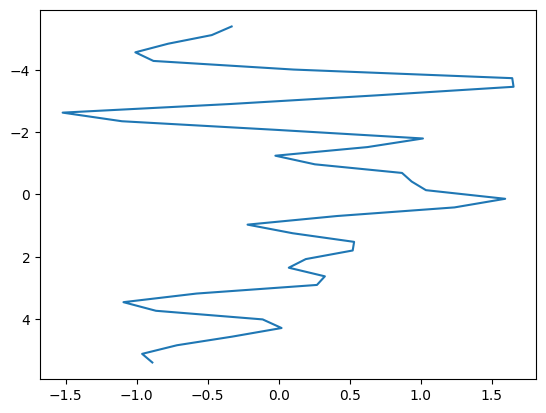

In [5]:
plt.plot(x[0, :], t);
plt.gca().invert_yaxis();

## split

In [6]:
x_trn, x_val, y_trn, y_val = train_test_split(x, y, test_size = 0.1)
x_tst, y_tst = data['x_test'], data['y_test']
(x_trn.shape, y_trn.shape), (x_val.shape, y_val.shape), (x_tst.shape, y_tst.shape)

(((3600, 40), (3600,)), ((400, 40), (400,)), ((1000, 40), (1000,)))

## loader

In [7]:
class MNIST1D(Dataset):
    def __init__(self, db):
        self.db = db
        self.db['x'] = torch.Tensor(self.db['x'])
        self.db['y'] = torch.LongTensor(self.db['y'])

    def __len__(self):
        return self.db['x'].shape[0]
    
    def __getitem__(self, idx):
        return {'x': self.db['x'][idx, :], 'y': self.db['y'][idx]}

# model

In [8]:
class MLP(nn.Module):
    def __init__(self, depth, xs = 40, ys = 10, hs = 100):
        super(MLP, self).__init__()
        self.depth = depth

        self.first = nn.Linear(xs, hs)
        self.linears = nn.ModuleList([nn.Linear(hs, hs) for u in range(self.depth)])
        self.last = nn.Linear(hs, ys)
    
    def forward(self, x):
        h = self.first(x).relu()
        for u in range(self.depth):
            h = h + self.linears[u](h).relu()
        return self.last(h)

# baseline

In [9]:
def trn_loop(model, loader, optimizer, criterion):
    model.train()
    
    log = 0
    for batch in (loader):
        x, y = [u.to(device) for u in batch.values()]
        
        yhat = model.forward(x)
        loss = criterion(yhat, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        log += loss.item()
    log /= loader.dataset.__len__()
    return log

In [10]:
def val_loop(model, loader, criterion):
    model.eval()

    log = 0
    with torch.no_grad():
        for batch in (loader):
            x, y = [u.to(device) for u in batch.values()]
            
            yhat = model.forward(x)
            loss = criterion(yhat, y)
            
            log += loss.item()
    log /= loader.dataset.__len__()
    return log

In [11]:
def tst_loop(model, loader, criterion):
    model.eval()

    log = 0
    acc = 0
    with torch.no_grad():
        for batch in (loader):
            x, y = [u.to(device) for u in batch.values()]
            
            yhat = model.forward(x)
            loss = criterion(yhat, y)

            log += loss.item()
            acc += np.sum(yhat.argmax(-1).cpu().numpy() == y.cpu().numpy())
    log /= loader.dataset.__len__()
    acc /= loader.dataset.__len__()
    return log, acc

In [12]:
ds_trn = MNIST1D(db = {'x': x_trn, 'y': y_trn})
ds_val = MNIST1D(db = {'x': x_val, 'y': y_val})
ds_tst = MNIST1D(db = {'x': x_tst, 'y': y_tst})

trn_loader = DataLoader(ds_trn, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, shuffle = True)
val_loader = DataLoader(ds_val, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, shuffle = False)
tst_loader = DataLoader(ds_tst, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, shuffle = False)

In [13]:
def baseline(depth, loaders, lr):
    trn_loader, val_loader, tst_loader = loaders

    model = MLP(depth = depth)
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = lr)

    trn_log = []
    val_log = []
    minimo = 1e3
    for epoch in tqdm(range(EPOCHS)):
        trn_log.append(trn_loop(model, trn_loader, optimizer, criterion))
        val_log.append(val_loop(model, val_loader, criterion))
        if val_log[-1] < minimo:
            minimo = val_log[-1]
            torch.save(model.state_dict(), 'output/partial.pt')
    model.load_state_dict(torch.load('output/partial.pt'))
    
    plt.plot(trn_log);
    plt.plot(val_log);

    minimo = np.min(val_log)
    plt.axhline(y = minimo, color = 'black', linestyle = 'dashed');
    print(minimo, np.argmin(val_log))

    print(tst_loop(model, tst_loader, criterion))

100%|██████████| 100/100 [00:45<00:00,  2.18it/s]

0.010021260529756547 33


(0.010764634013175964, 0.571)


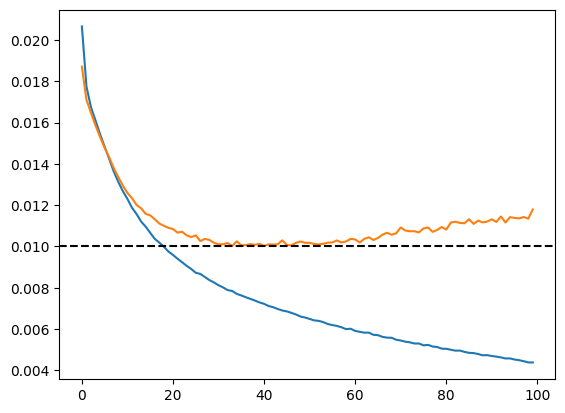

In [14]:
baseline(depth = 0, loaders = [trn_loader, val_loader, tst_loader], lr = 2e-3)

100%|██████████| 100/100 [00:47<00:00,  2.12it/s]

0.00978649839758873 37


(0.01029985111951828, 0.598)


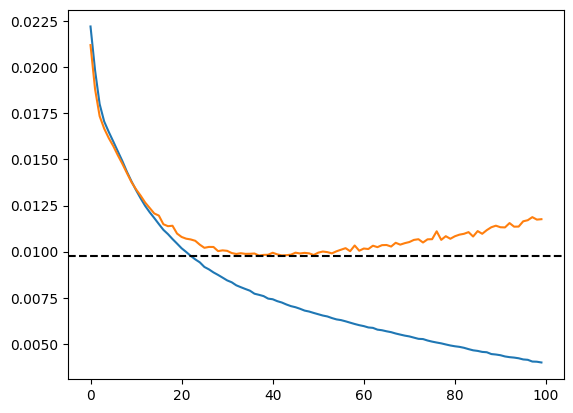

In [16]:
baseline(depth = 1, loaders = [trn_loader, val_loader, tst_loader], lr = 6e-4)

100%|██████████| 100/100 [00:48<00:00,  2.06it/s]

0.009705709964036942 50


(0.010650469064712524, 0.593)


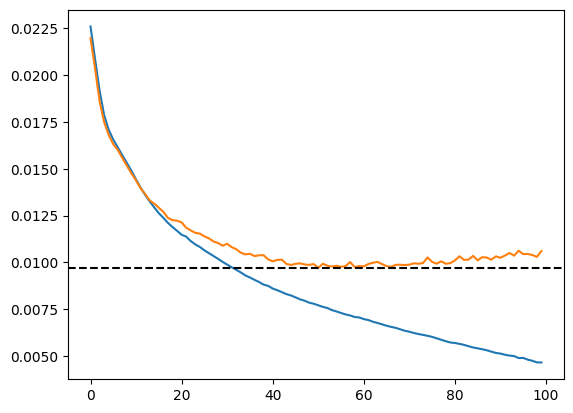

In [17]:
baseline(depth = 2, loaders = [trn_loader, val_loader, tst_loader], lr = 3e-4)

100%|██████████| 100/100 [00:49<00:00,  2.02it/s]

0.00995401531457901 52


(0.011386447131633759, 0.583)


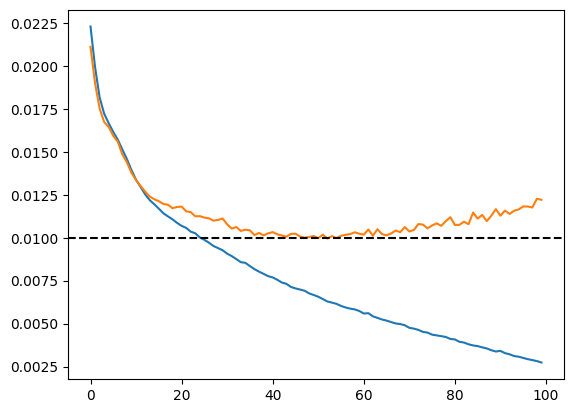

In [18]:
baseline(depth = 3, loaders = [trn_loader, val_loader, tst_loader], lr = 3e-4)

100%|██████████| 100/100 [00:51<00:00,  1.96it/s]

0.0102767314016819 52


(0.01155636465549469, 0.566)


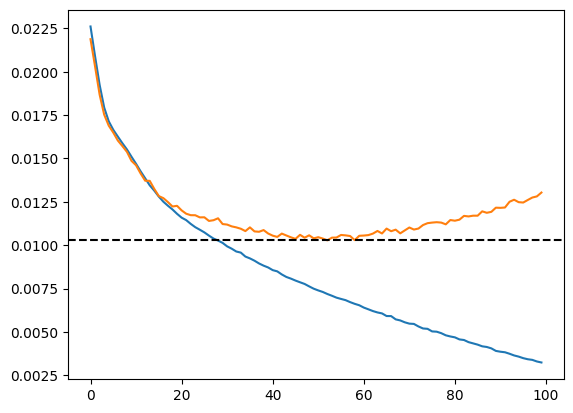

In [20]:
baseline(depth = 4, loaders = [trn_loader, val_loader, tst_loader], lr = 2e-4)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:51<00:00,  1.93it/s]

0.01052974671125412 44


(0.010895144760608672, 0.568)


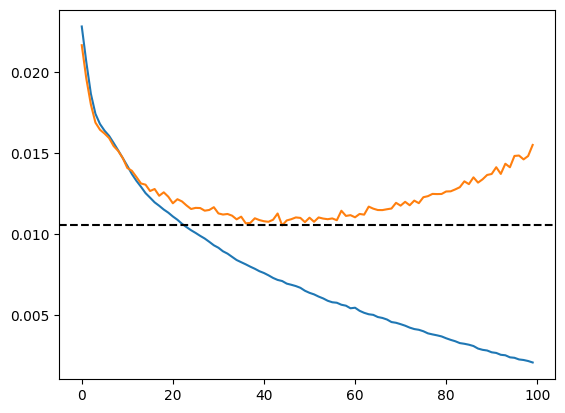

In [22]:
baseline(depth = 5, loaders = [trn_loader, val_loader, tst_loader], lr = 2e-4)

100%|██████████| 100/100 [00:53<00:00,  1.88it/s]

0.0102140773832798 39


(0.011791077613830567, 0.566)


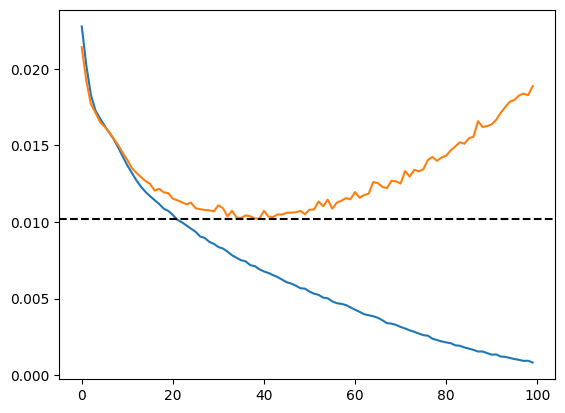

In [23]:
baseline(depth = 6, loaders = [trn_loader, val_loader, tst_loader], lr = 2e-4)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:54<00:00,  1.85it/s]

0.010999698489904404 71


(0.011241230070590974, 0.572)


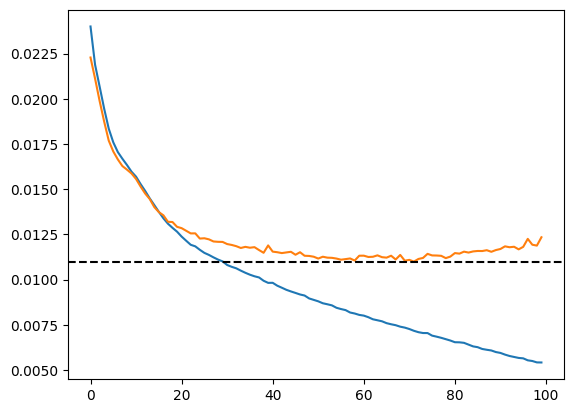

In [24]:
baseline(depth = 7, loaders = [trn_loader, val_loader, tst_loader], lr = 1e-4)